In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf

from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib

tf.logging.set_verbosity(tf.logging.INFO)

In [28]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features, [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv11 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

  # Convolutional Layer #1
  conv12 = tf.layers.conv2d(
      inputs=conv11,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv12, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv21 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

  conv22 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    
  pool2 = tf.layers.max_pooling2d(inputs=conv22, pool_size=[2, 2], strides=2)

  # Dense Layer
  print (pool2.shape)
  pool2_flat = tf.reshape(pool2, [-1, int(pool2.shape[1] * pool2.shape[2] * pool2.shape[3])])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == learn.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  loss = None
  train_op = None

  # Calculate Loss (for both TRAIN and EVAL modes)
  if mode != learn.ModeKeys.INFER:
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=10)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == learn.ModeKeys.TRAIN:
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=0.001,
        optimizer="SGD")

  # Generate Predictions
  predictions = {
      "classes": tf.argmax(
          input=logits, axis=1),
      "probabilities": tf.nn.softmax(
          logits, name="softmax_tensor")
  }

  # Return a ModelFnOps object
  return model_fn_lib.ModelFnOps(
      mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In [3]:
# Load training and eval data
mnist = learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [36]:
mnist_classifier = learn.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/mnist_convnet_model_3")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5801e24e90>, '_model_dir': '/tmp/mnist_convnet_model_3', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_save_summary_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}


In [37]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=50)

# Train the model
mnist_classifier.fit(
    x=train_data,
    y=train_labels,
    batch_size=100,
    steps=20000)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
(?, 7, 7, 64)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpo

Estimator(params=None)

In [38]:
metrics = {
    "accuracy":
        learn.MetricSpec(
            metric_fn=tf.metrics.accuracy, prediction_key="classes"),
}

eval_results = mnist_classifier.evaluate(
    x=eval_data, y=eval_labels, metrics=metrics)
print(eval_results)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
(?, 7, 7, 64)
INFO:tensorflow:Starting evaluation at 2017-08-01-07:17:57
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model_3/model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2017-08-01-07:18:01
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.9756, global_step = 20000, loss = 0.0769367
{'loss': 0.076936655, 'global_step': 20000, 'accuracy': 0.9756}


In [5]:
x = tf.placeholder(tf.float32, [None, 784])
x_reshaped = tf.reshape(x, [-1, 28, 28, 1])


# Convolutional Layer #1
conv11 = tf.layers.conv2d(
  inputs=x_reshaped,
  filters=32,
  kernel_size=[3, 3],
  padding="same",
  activation=tf.nn.relu)

# Convolutional Layer #1
conv12 = tf.layers.conv2d(
  inputs=conv11,
  filters=32,
  kernel_size=[3, 3],
  padding="same",
  activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv12, pool_size=[2, 2], strides=2)

# Convolutional Layer #2 and Pooling Layer #2
conv21 = tf.layers.conv2d(
  inputs=pool1,
  filters=64,
  kernel_size=[3, 3],
  padding="same",
  activation=tf.nn.relu)

conv22 = tf.layers.conv2d(
  inputs=pool1,
  filters=64,
  kernel_size=[3, 3],
  padding="same",
  activation=tf.nn.relu)


pool2 = tf.layers.max_pooling2d(inputs=conv22, pool_size=[2, 2], strides=2)

pool2_flat = tf.reshape(pool2, [-1, int(pool2.shape[1] * pool2.shape[2] * pool2.shape[3])])
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
dropout = tf.layers.dropout(inputs=dense, rate=0.4)

# Logits Layer
y = tf.layers.dense(inputs=dropout, units=10)


labels_ = tf.placeholder(tf.float32, [None])
y_ = tf.one_hot(indices=tf.cast(labels_, tf.int32), depth=10)

cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels=y_, logits=y)


correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
for i in range(20):
    for _ in range(500):
      batch_xs, batch_ys = mnist.train.next_batch(100)
      sess.run(train_step, feed_dict={x: batch_xs, labels_: batch_ys})
    #train_accuracy = accuracy.eval(feed_dict=({x: mnist.train.images, labels_: mnist.train.labels}))
    test_accuracy = accuracy.eval(feed_dict=({x: mnist.test.images, labels_: mnist.test.labels}))
    c_eval = cross_entropy.eval(feed_dict=({x: mnist.test.images, labels_:  mnist.test.labels}))
    preds = y.eval(feed_dict=({x: batch_xs, labels_: batch_ys}))
    print ("Epoch: ", i, "Test acc: ", test_accuracy, 'Loss:', c_eval)
    


Epoch:  0 Test acc:  0.9197 Loss: 0.266715
Epoch:  1 Test acc:  0.954 Loss: 0.146833
Epoch:  2 Test acc:  0.9654 Loss: 0.117083
Epoch:  3 Test acc:  0.9742 Loss: 0.0833736
Epoch:  4 Test acc:  0.9776 Loss: 0.0708224
Epoch:  5 Test acc:  0.9814 Loss: 0.0576688
Epoch:  6 Test acc:  0.9799 Loss: 0.0618946
Epoch:  7 Test acc:  0.9807 Loss: 0.0557375
Epoch:  8 Test acc:  0.9843 Loss: 0.0473123
Epoch:  9 Test acc:  0.9846 Loss: 0.0464348
Epoch:  10 Test acc:  0.9837 Loss: 0.0470667
Epoch:  11 Test acc:  0.9863 Loss: 0.0420192
Epoch:  12 Test acc:  0.9855 Loss: 0.0417595
Epoch:  13 Test acc:  0.9866 Loss: 0.0389509
Epoch:  14 Test acc:  0.9877 Loss: 0.0387053
Epoch:  15 Test acc:  0.9878 Loss: 0.0368648
Epoch:  16 Test acc:  0.9874 Loss: 0.035044
Epoch:  17 Test acc:  0.9859 Loss: 0.0420563
Epoch:  18 Test acc:  0.9875 Loss: 0.0373499
Epoch:  19 Test acc:  0.988 Loss: 0.0356115


In [7]:
conv11_eval = conv11.eval(feed_dict=({x: mnist.test.images[:1], labels_:  mnist.test.labels[:1]}))

In [8]:
print (conv11_eval.shape)

(1, 28, 28, 32)


In [12]:
conv11_eval = np.reshape(conv11_eval, (28, 28, 32))

In [13]:
conv11_eval

array([[[ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        [ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        [ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        ..., 
        [ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        [ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        [ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123]],

       [[ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        [ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        [ 0.09212791,  0.00026866,  0.        , ...,  0.00684976,
          0.00014891,  0.01691123],
        ..., 
        [ 0.09212791,  0.00026866,  0.        , ...,

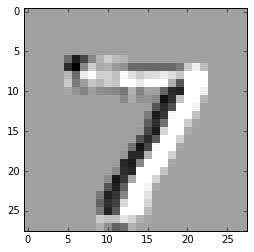

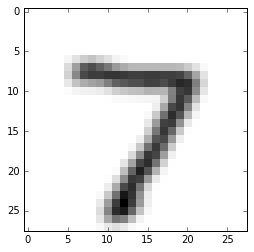

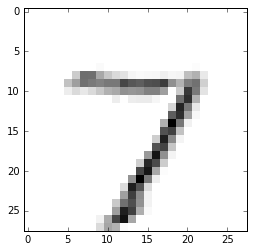

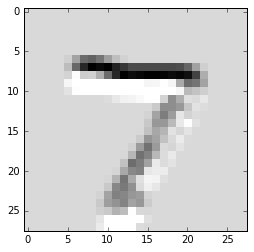

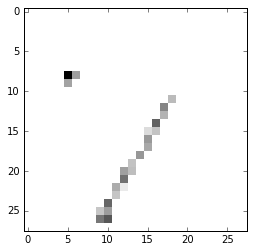

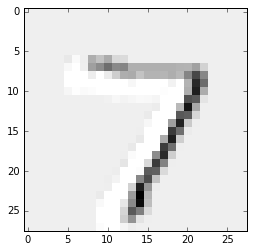

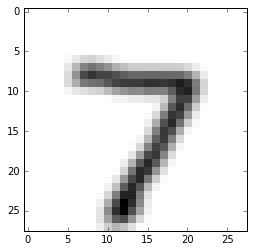

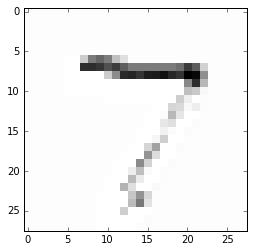

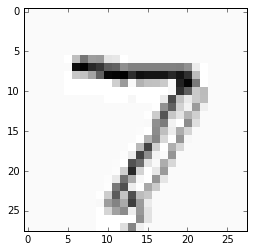

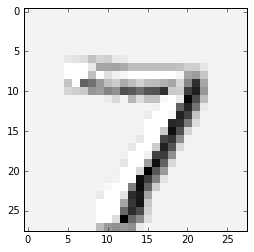

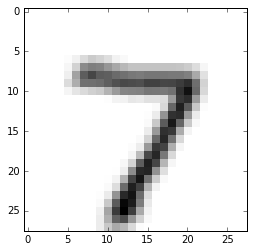

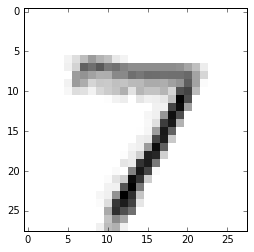

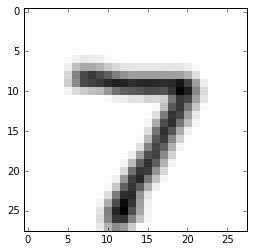

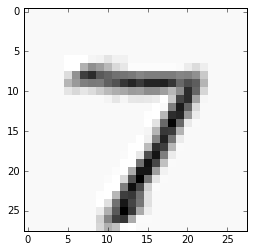

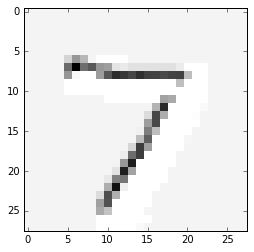

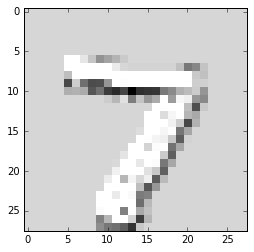

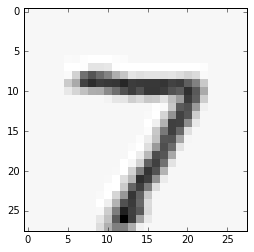

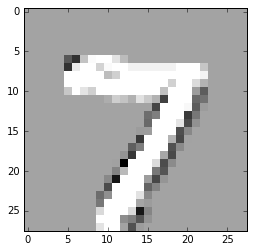

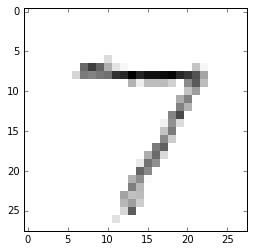

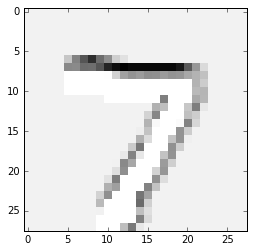

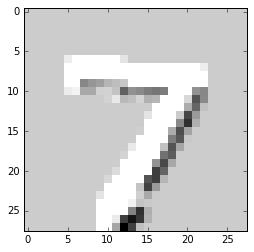

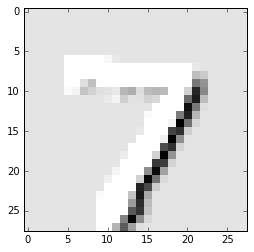

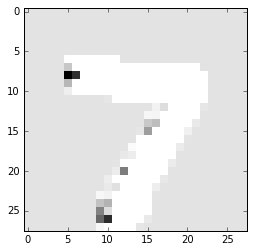

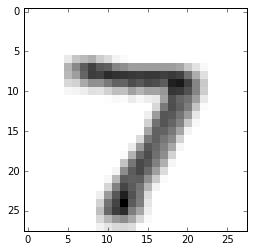

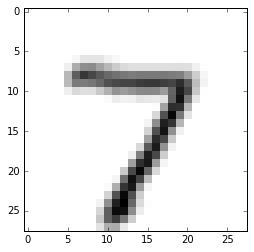

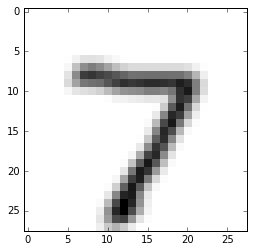

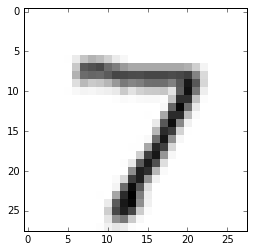

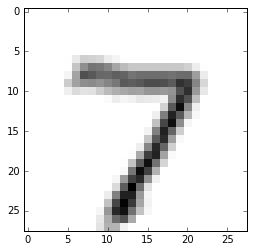

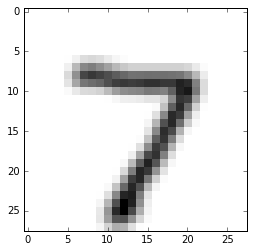

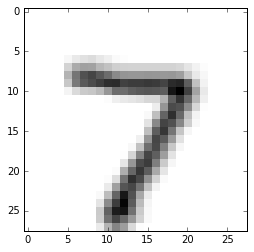

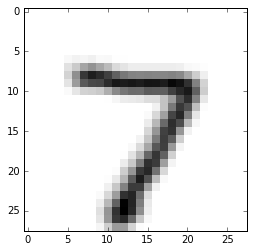

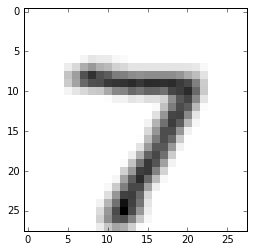

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

for i in range(32):
    x = np.array(conv11_eval[:, :, i])
    nrows, ncols = 28, 28
    grid = np.reshape(x, (nrows, ncols))

    plt.imshow(grid, interpolation='nearest', cmap='binary')
    plt.show()